In [1]:
import matplotlib.pyplot as plt

from superfv import EulerSolver, plot_1d_slice, OutputLoader
from superfv.initial_conditions import shu_osher

In [2]:
T = 0.178
N = 400

ref_path = "../out/shu-osher/ref"

configs = {
    "ref": dict(
        p=1,
        riemann_solver="hllc",
        flux_recipe=2,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "MUSCL-Hancock": dict(
        p=1,
        riemann_solver="hllc",
        flux_recipe=2,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "ZS3": dict(
        p=3,
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives="adaptive",
        ZS=True,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM3, atol=1": dict(
        p=3,
        riemann_solver="hllc",
        flux_recipe=2,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1,
        NAD_atol=1e-8,
        absolute_dmp=False,
        SED=True,
    ),
    "MM3, atol=0.1": dict(
        p=3,
        riemann_solver="hllc",
        flux_recipe=2,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-1,
        NAD_atol=1e-8,
        absolute_dmp=False,
        SED=True,
    ),
    "MM3, atol=0.01": dict(
        p=3,
        riemann_solver="hllc",
        flux_recipe=2,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        absolute_dmp=False,
        SED=True,
    ),
}

sims = {}
for name, config in configs.items():
    if name == "ref":
        try:
            sim = OutputLoader(ref_path)
            sims[name] = sim
            continue
        except FileNotFoundError:
            pass

    print(f"Running {name}...")
    sim = EulerSolver(
        ic=shu_osher,
        bcx="free",
        nx=10000 if name == "ref" else N,
        **config,
    )

    try:
        sim.run(
            T,
            q_max=2,
            muscl_hancock=config.get("MUSCL", False),
            path=ref_path if name == "ref" else None,
            allow_overshoot=True,
        )
    except Exception as e:
        print(f"Failed: {e}")
        continue

    sims[name] = sim

Successfully read simulation output from "../out/shu-osher/ref"
Running MUSCL-Hancock...
Step #424 @ t=1.78e-01 | dt=4.18e-04 | min(rho)=8.00e-01, min(P)=1.00e+00 | (ran in 0.42s)          
Running ZS3...
Step #426 @ t=1.78e-01 | dt=4.17e-04 | min(rho)=8.00e-01, min(P)=1.00e+00 | (ran in 2.37s)          
Running MM3, atol=1...
Step #431 @ t=1.78e-01 | dt=4.17e-04 | min(rho)=8.00e-01, min(P)=8.80e-01 | (ran in 2.23s)          
Running MM3, atol=0.1...
Step #424 @ t=1.78e-01 | dt=4.18e-04 | min(rho)=8.00e-01, min(P)=9.81e-01 | (ran in 2.36s)          
Running MM3, atol=0.01...
Step #424 @ t=1.78e-01 | dt=4.19e-04 | min(rho)=8.00e-01, min(P)=9.85e-01 | (ran in 2.30s)          


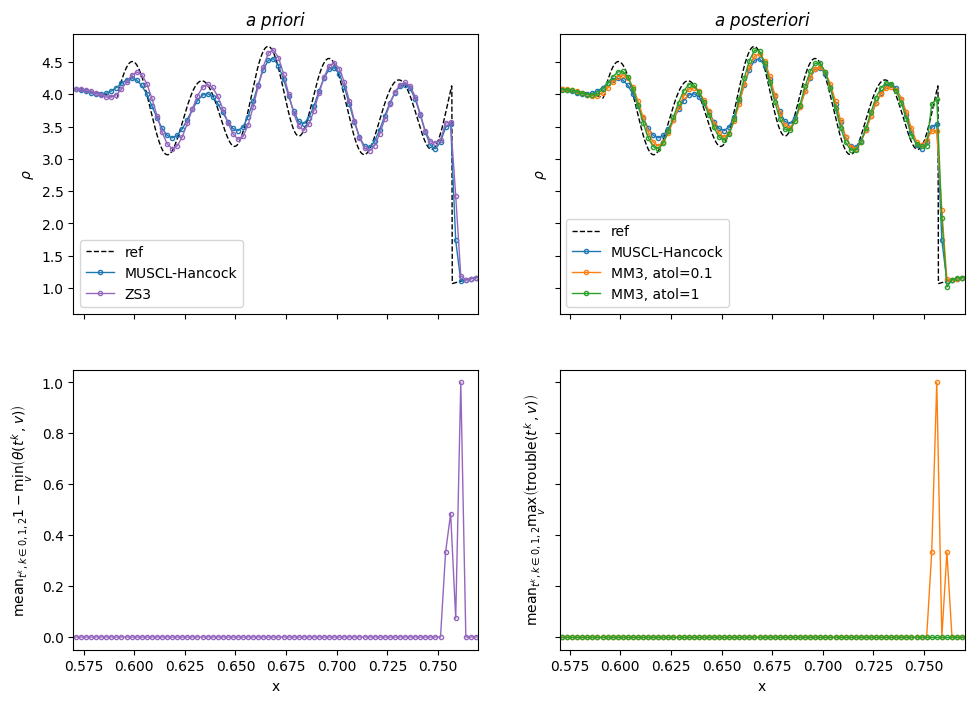

In [ ]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey="row", figsize=(11.5, 8))
axs[0, 0].set_title(r"$\it{a\ priori}$")
axs[0, 1].set_title(r"$\it{a\ posteriori}$")
axs[0, 0].set_ylabel(r"$\rho$")
axs[0, 1].set_ylabel(r"$\rho$")
axs[1, 0].set_ylabel(
    r"$\text{mean}_{t^k, k \in 0,1,2} 1 - \min_v \left( \theta(t^k, v) \right) $"
)
axs[1, 1].set_ylabel(
    r"$\text{mean}_{t^k, k \in 0,1,2} \max_v \left( \text{trouble}(t^k, v) \right) $"
)
axs[1, 0].set_xlabel("x")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_xlim(0.57, 0.77)

ref = sims["ref"]
sim0 = sims["MUSCL-Hancock"]
sim1 = sims["ZS3"]
sim2 = sims["MM3, atol=1"]
sim3 = sims["MM3, atol=0.1"]
sim4 = sims["MM3, atol=0.01"]

style = dict(cell_averaged=True, linestyle="--", color="k", linewidth=1)

# reference solution
plot_1d_slice(ref, axs[0, 0], "rho", label="ref", **style)
plot_1d_slice(ref, axs[0, 1], "rho", label="ref", **style)

style = dict(cell_averaged=True, marker="o", mfc="none", linewidth=1, markersize=3)

# MUSCL-Hancock
plot_1d_slice(sim0, axs[0, 0], "rho", label="MUSCL-Hancock", **style, color="tab:blue")
plot_1d_slice(sim0, axs[0, 1], "rho", label="MUSCL-Hancock", **style, color="tab:blue")

# ZS3
plot_1d_slice(sim1, axs[0, 0], "rho", label="ZS3", **style, color="tab:purple")
plot_1d_slice(
    sim1,
    axs[1, 0],
    "rho",
    label="ZS3",
    **style,
    color="tab:purple",
    theta=True,
    func=lambda x: 1 - x,
)

# MM3
plot_1d_slice(
    sim3, axs[0, 1], "rho", label="MM3, atol=0.1", **style, color="tab:orange"
)
plot_1d_slice(
    sim3,
    axs[1, 1],
    "rho",
    label="MM3, atol=0.1",
    **style,
    color="tab:orange",
    troubles=True,
)

plot_1d_slice(sim2, axs[0, 1], "rho", label="MM3, atol=1", **style, color="tab:green")
plot_1d_slice(
    sim2,
    axs[1, 1],
    "rho",
    label="MM3, atol=1",
    **style,
    color="tab:green",
    troubles=True,
)

axs[0, 0].legend()
axs[0, 1].legend()